# TL08 Arquitecturas comunes

## Ejercicio: realiza un experimento similar al de transfer learning con aumento de datos

Inicialización: librerías, semilla, lectura de CIFAR-10 y partición train-val-test

In [2]:
import numpy as np; import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; from keras import layers
keras.utils.set_random_seed(23)
(x_train_val, y_train_val), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")
y_train_val = keras.utils.to_categorical(y_train_val, 10)
y_test = keras.utils.to_categorical(y_test, 10)
x_train = x_train_val[:-10000]; x_val = x_train_val[-10000:]
y_train = y_train_val[:-10000]; y_val = y_train_val[-10000:]
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
(40000, 32, 32, 3) (40000, 10) (10000, 32, 32, 3) (10000, 10) (10000, 32, 32, 3) (10000, 10)


Construcción del modelo: ResNet50V2 descabezada con entrada ajustada y nueva cabeza entrenable -->  añadimos reflexiones horizontales y translaciones

In [3]:
inputs = keras.Input(shape=(32, 32, 3))
x = layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)
x = layers.RandomFlip(mode="horizontal")(x)
factor = 2.0 / 32.0
x = layers.RandomTranslation(factor, factor, fill_mode="nearest")(x)
x = layers.Resizing(224, 224, interpolation="nearest")(x)
base_M = keras.applications.resnet_v2.ResNet50V2(include_top=False)
base_M.trainable = False
x = base_M(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(units=800, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(10, activation='softmax')(x)
M = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Entrenamiento del modelo: guardamos el mejor modelo con un callback checkpoint

In [4]:
filename = 'CIFAR10_transfer_learning.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
 filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
 monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0005)
H = M.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val), verbose=0,
 callbacks=[checkpoint_cb, early_cb, reduce_cb])



Epoch 1: val_accuracy improved from -inf to 0.87820, saving model to CIFAR10_transfer_learning.keras

Epoch 2: val_accuracy improved from 0.87820 to 0.88170, saving model to CIFAR10_transfer_learning.keras

Epoch 3: val_accuracy improved from 0.88170 to 0.88620, saving model to CIFAR10_transfer_learning.keras

Epoch 4: val_accuracy did not improve from 0.88620

Epoch 5: val_accuracy improved from 0.88620 to 0.88840, saving model to CIFAR10_transfer_learning.keras

Epoch 6: val_accuracy improved from 0.88840 to 0.89100, saving model to CIFAR10_transfer_learning.keras

Epoch 7: val_accuracy improved from 0.89100 to 0.89220, saving model to CIFAR10_transfer_learning.keras

Epoch 8: val_accuracy did not improve from 0.89220

Epoch 9: val_accuracy improved from 0.89220 to 0.89600, saving model to CIFAR10_transfer_learning.keras

Epoch 10: val_accuracy did not improve from 0.89600

Epoch 11: val_accuracy did not improve from 0.89600

Epoch 12: val_accuracy did not improve from 0.89600

Epoc

KeyboardInterrupt: 

NameError: name 'H' is not defined

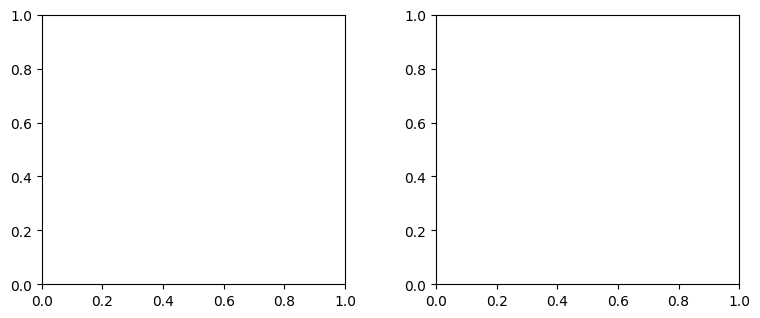

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5)); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); # ax.set_xticks(xx)
ax.set_xlabel('epoch'); ax.set_ylabel('loss')
ax.plot(xx, H.history['loss'], color='b', label='train')
ax.plot(xx, H.history['val_loss'], color='r', label='val'); ax.legend()
ax = axes[1]; ax.grid(); # ax.set_xticks(xx)
ax.set_xlabel('epoch'); ax.set_ylabel('accuracy')
ax.plot(xx, H.history['accuracy'], color='b', label='train')
ax.plot(xx, H.history['val_accuracy'], color='r', label='val'); ax.legend();

Evaluación en test:

In [ ]:
score = keras.models.load_model(filename).evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4} Precisión: {score[1]:.2%}')


**Fine-tuning**: re-entrenamos muy suavemente todo el modelo salvo capas BatchNorm

In [ ]:
M = keras.models.load_model('CIFAR10_transfer_learning.keras')
M.trainable = True
for layer in M.layers:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True
opt = keras.optimizers.Adam(learning_rate=1e-5)
M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
filename = 'CIFAR10_fine-tuning.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
  filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
  monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0005)
H = M.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val), verbose=0,
  callbacks=[checkpoint_cb, early_cb, reduce_cb])


Epoch 1: val_accuracy improved from -inf to 0.91010, saving model to CIFAR10_fine-tuning.keras

Epoch 2: val_accuracy improved from 0.91010 to 0.92970, saving model to CIFAR10_fine-tuning.keras

Epoch 3: val_accuracy improved from 0.92970 to 0.94430, saving model to CIFAR10_fine-tuning.keras


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5)); plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('loss'); ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], color='b', marker='s', label='train')
ax.plot(xx, H.history['val_loss'], color='r', marker='x', label='val'); ax.legend()
ax = axes[1]; ax.grid(); ax.set_xlabel('epoch'); ax.set_ylabel('accuracy'); ax.set_xticks(xx)
ax.plot(xx, H.history['accuracy'], color='b', marker='s', label='train')
ax.plot(xx, H.history['val_accuracy'], color='r', marker='x', label='val'); ax.legend();

In [ ]:
score = keras.models.load_model(filename).evaluate(x_test, y_test, verbose=0)
print(f'Loss: {score[0]:.4} Precisión: {score[1]:.2%}')
